# Interpretability of heartbeat classification using integrated gradients and a CNN model

In [67]:
# Imports
import numpy as np
import pandas as pd
import glob
import os
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import *
import tensorflow as tf
from sklearn.utils import class_weight
from sklearn.metrics import log_loss
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import Input
from tensorflow.keras.layers import Dense, BatchNormalization, MaxPooling1D, Conv1D, Flatten
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import activations
from alibi.explainers import IntegratedGradients
from itertools import islice
from sklearn.preprocessing import normalize
sns.set()

length = 277

### Extract task-specific data

In [13]:
# Load the training and testing data:
train_values = np.empty(shape=[0, length])
test_values = np.empty(shape=[0, length])

train_beats = glob.glob('./train_beats.csv')
test_beats = glob.glob('./test_beats.csv')

for j in train_beats:
    print('Loading ', j)
    csvrows = np.loadtxt(j, delimiter=',')
    train_values = np.append(train_values, csvrows, axis=0)

for j in test_beats:
    print('Loading ', j)
    csvrows = np.loadtxt(j, delimiter=',')
    test_values = np.append(test_values, csvrows, axis=0)
    
print(train_values.shape)
print(test_values.shape)

# Separate the training and testing data:
X_train = train_values[:,:-2]
X_test = test_values[:,:-2]
X_train = np.reshape(X_train, (-1, X_train.shape[1], 1))

y_train = train_values[:,-2]
y_test = test_values[:,-2]
y_train = to_categorical(y_train)

Loading  ../../../mimic3-code-main/module2_week1/train_beats.csv
Loading  ../../../mimic3-code-main/module2_week1/test_beats.csv
(31912, 277)
(37863, 277)


### Create a performance metrics function

In [74]:
def showResults(test, pred, model_name):
    accuracy = accuracy_score(test, pred)
    precision= precision_score(test, pred, average='macro')
    recall = recall_score(test, pred, average = 'macro')
    f1score= f1_score(test, pred, average='macro') 
    print("Accuracy  : {}".format(accuracy))
    print("Precision : {}".format(precision))
    print("Recall : {}".format(recall))
    print("f1score : {}".format(f1score))
    cm=confusion_matrix(test, pred, labels=[1,2,3,4,5,6,7,8])
    return (model_name, round(accuracy,3), round(precision,3) , round(recall,3) , round(f1score,3), cm)

### Load the previously trained CNN model or retrain the model, and predict on the test data

In [16]:
verbose, epoch, batch_size = 1, 10, 64
activationFunction='relu'

def getModel(): 
    cnnmodel = Sequential()
    cnnmodel.add(Conv1D(filters=128, kernel_size=16,padding='same', activation='relu',input_shape=(X_train.shape[1], X_train.shape[2])))
    cnnmodel.add(BatchNormalization())
    cnnmodel.add(Conv1D(filters=32, kernel_size=16,padding='same', activation='relu'))
    cnnmodel.add(BatchNormalization())
    cnnmodel.add(Conv1D(filters=9, kernel_size=16,padding='same', activation='relu', name = 'last_conv_layer'))
    cnnmodel.add(MaxPooling1D(pool_size=4,padding='same'))
    cnnmodel.add(Flatten())
    cnnmodel.add(Dense(256, activation='relu'))
    cnnmodel.add(Dense(128, activation='relu'))
    cnnmodel.add(Dense(32, activation='relu'))
    cnnmodel.add(Dense(9, activation='softmax'))
    cnnmodel.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy'])
    cnnmodel.summary()
    return cnnmodel

cnnmodel = getModel()
cnnhistory= cnnmodel.fit(X_train, y_train, epochs=epoch, verbose=verbose, validation_split=0.2, batch_size = batch_size)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 275, 128)          2176      
_________________________________________________________________
batch_normalization (BatchNo (None, 275, 128)          512       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 275, 32)           65568     
_________________________________________________________________
batch_normalization_1 (Batch (None, 275, 32)           128       
_________________________________________________________________
last_conv_layer (Conv1D)     (None, 275, 9)            4617      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 69, 9)             0         
_________________________________________________________________
flatten (Flatten)            (None, 621)              

In [ ]:
# Save the model so we can visualize it with Netron (https://github.com/lutzroeder/netron):
tf.keras.models.save_model(cnnmodel, 'cnnmodel_integrad.h5')

### Choose a class for integrated gradients and make a prediction

In [184]:
# Get all the data that corresponds to one single class (class 8 / 'I'):
class_num = 8
class_ann = 'I'

N_test = test_values[test_values[:,-2]==class_num]

X_test = N_test[:,:-2]
y_test = N_test[:len(N_test),-2]

X_test1 = X_test.reshape(-1, X_test.shape[1], 1)
y_test1 = to_categorical(y_test)

In [185]:
cnnpredictions = cnnmodel.predict(X_test1, verbose=1)

76/76 [==============================] - 0s 6ms/step


### Call the performance metrics function per class

Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
invalid value encountered in true_divide


Accuracy  : 0.9883672621520565
Precision : 0.5
Recall : 0.49418363107602825
f1score : 0.4970748015043878


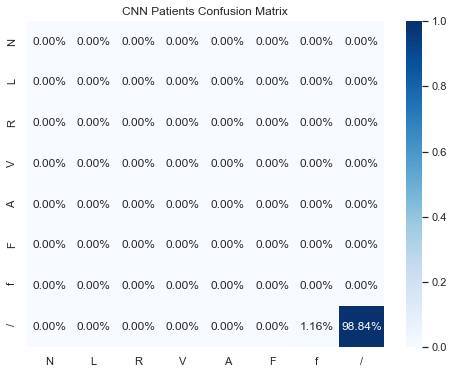

In [186]:
cnn_predict=np.argmax(cnnpredictions,axis=1)
cnn_actual_value=np.argmax(y_test1,axis=1)
cnn_results = showResults(cnn_actual_value, cnn_predict,'CNN')

cnnmetrics = classification_report(cnn_actual_value, cnn_predict, digits=3)
categories=['N','L','R','V','A','F','f','/']
fig = plt.figure(figsize=(8,6))
CNN_cf_m = cnn_results[5].astype('float')/ cnn_results[5].sum(axis=1)[:,np.newaxis]
sns.heatmap(np.nan_to_num(CNN_cf_m),annot=True,fmt='.2%',xticklabels=categories,yticklabels=categories,vmin=0,vmax=1,cmap='Blues')
plt.title('CNN Patients Confusion Matrix')
plt.show()
fig.savefig('cm.jpg', dpi = 400)

### Calculate the integrated gradients for the instances within the specified class

In [187]:
# Initialize the integrated gradients instance. We will use 100 steps to go from the 'baseline' to the input. The path 
# from baseline to input is defined by the Gauss-Legendre method.
ig  = IntegratedGradients(cnnmodel,
                          method = "gausslegendre",
                          n_steps = 100,
                          internal_batch_size = 100)

In [189]:
# Get the predictions of the cnn model:
nums = 10000
predictions = cnnmodel(X_test1[:nums,:]).numpy().argmax(axis=1)

# Calculate the integrated gradients for the specified class:
explanation = ig.explain(X_test1[:nums,:],
                         baselines = None,
                         target = predictions)

In [190]:
# Get attribution values from the explanations:
attrs = explanation.attributions[0].sum(axis=2)
print('Attributions shape:', attrs.shape)

# Normalize the attributes:
attrs = np.abs(attrs)
attrs_norm = (attrs - attrs.min(axis=1, keepdims=True)) / (attrs.max(axis=1, keepdims=True) - attrs.min(axis=1, keepdims=True))

Attributions shape: (2407, 275)


### Visualize Integrated Gradients with saliency maps for the correctly classified beats

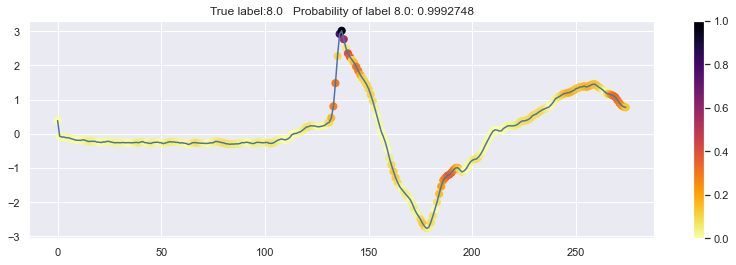

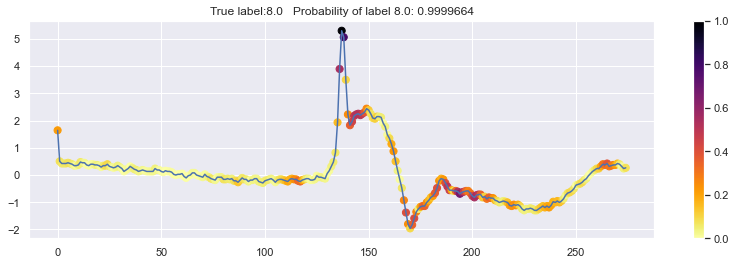

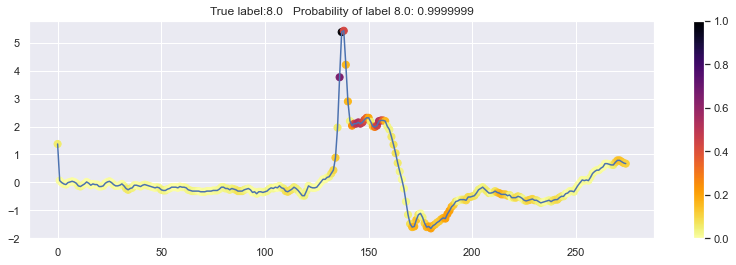

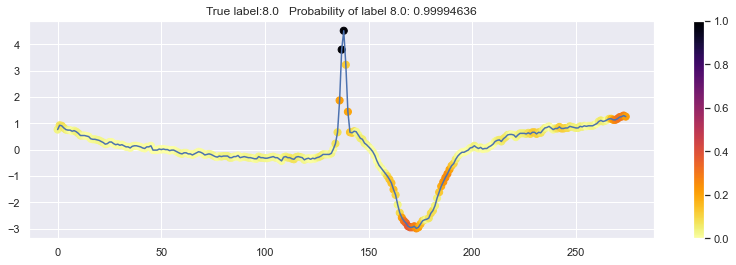

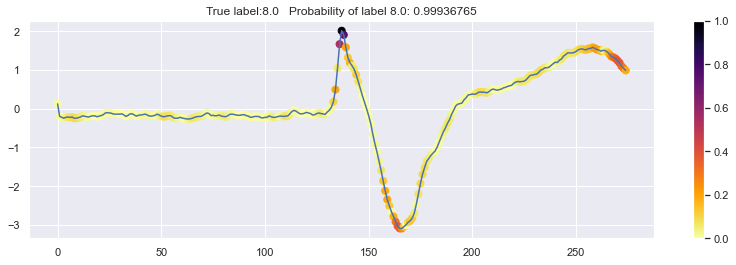

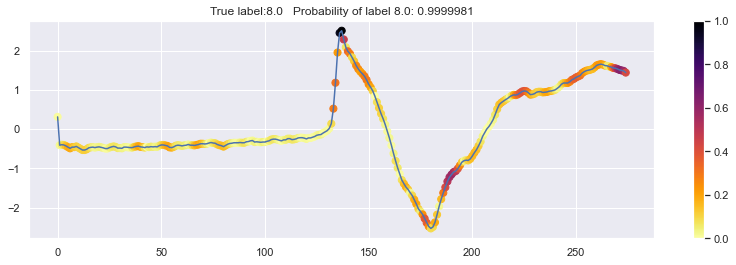

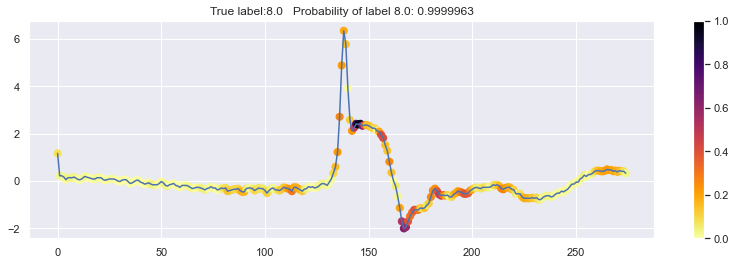

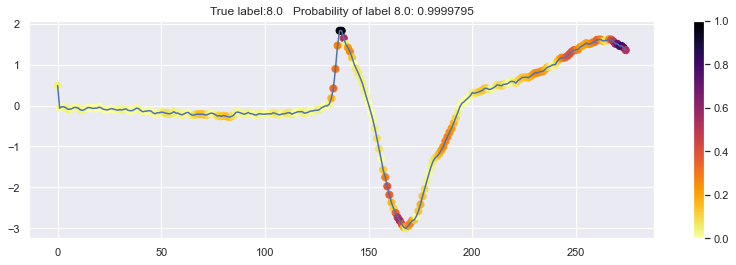

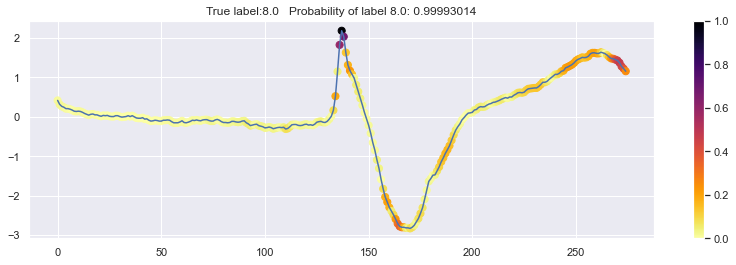

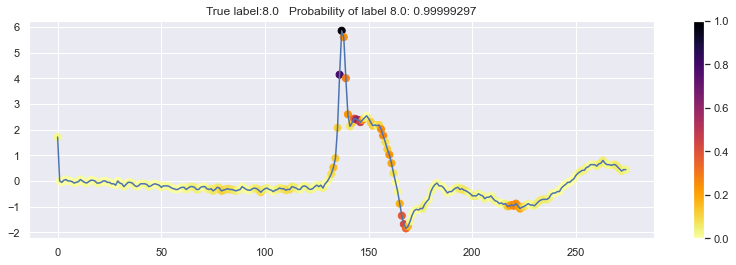

In [191]:
correct_attrs = np.where(cnn_predict==cnn_actual_value)
correct_attrs = correct_attrs[0].tolist()

for i in correct_attrs[:10]:
    plt.figure(figsize=(14, 4))
    plt.plot(X_test1[i].squeeze())
    plt.scatter(np.arange(len(X_test1[i])), X_test1[i].squeeze(), cmap='inferno_r', c=attrs_norm[i,:].squeeze(), s=50)
    plt.title('True label:' + str(y_test[i]) + '   Probability of label ' + str(y_test[i]) + ': ' + str(cnnpredictions[i][int(y_test[i])]))
    clim= np.ravel(attrs_norm)
    plt.clim(min(clim),max(clim))
    plt.colorbar()
    plt.show()

### Visualize Integrated Gradients with saliency maps for the heartbeats that were not correctly classified

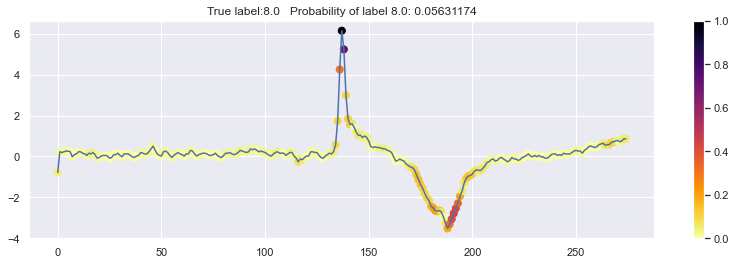

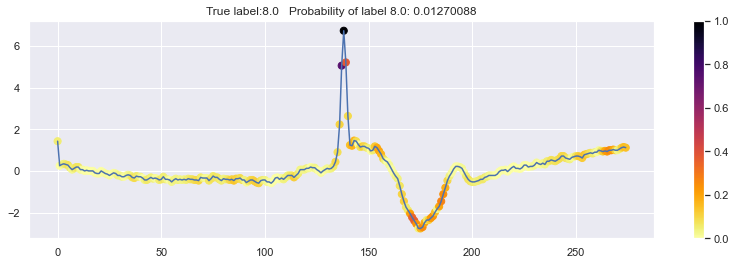

In [192]:
misclass_attrs = np.where(cnn_predict!=cnn_actual_value)
misclass_attrs = misclass_attrs[0].tolist()

for i in misclass_attrs[:2]:
    plt.figure(figsize=(14, 4))
    plt.plot(X_test1[i].squeeze())
    plt.scatter(np.arange(len(X_test1[i])), X_test1[i].squeeze(), cmap='inferno_r', c=attrs_norm[i,:].squeeze(), s=50)
    plt.title('True label:' + str(y_test[i]) + '   Probability of label ' + str(y_test[i]) + ': ' + str(cnnpredictions[i][int(y_test[i])]))
    clim= np.ravel(attrs_norm)
    plt.clim(min(clim),max(clim))
    plt.colorbar()
    plt.show()

### Divide the  ECG beats into 11 segments and compute the Integrated Gradients per segment

In [193]:
# Means of slice function:
def means_of_slices(iterable, slice_size):
    iterator = iter(iterable)
    while True:
        slice = list(islice(iterator, slice_size))
        if slice:
            yield np.sum(slice)/len(slice)
        else:
            return

# Divide the result into slices:
ig_per_segment = []
for i in range(len(attrs)):
    means = list(means_of_slices(attrs_norm[i], 25))
    ig_per_segment.append(means)
ig_per_segment = np.array(ig_per_segment)
print(ig_per_segment.shape)

# Repeat the values 25 times for visualization purposes:
ig_per_segment_repeat = []
for i in ig_per_segment:
    ig_per_segment_repeat.append(np.repeat(i, 25))
ig_per_segment_repeat = np.array(ig_per_segment_repeat)
print(ig_per_segment_repeat.shape)

(2407, 11)
(2407, 275)


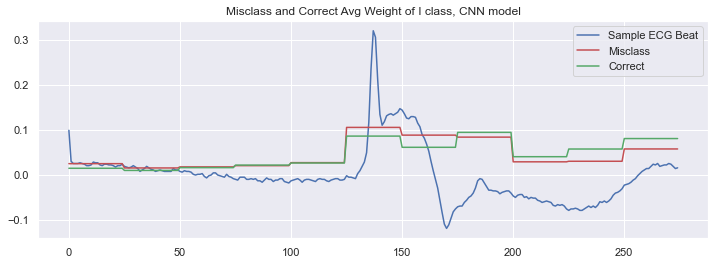

In [194]:
# Normalize correct and incorrect predictions and the ECG heartbeat:
ecg_correct_norm = normalize(ig_per_segment_repeat[correct_attrs])
ecg_incorrect_norm = normalize(ig_per_segment_repeat[misclass_attrs])
ecg_norm = normalize(X_test1[:, :, 0])

# Take means of all correct and incorrect segments:
mean_correct = ecg_correct_norm.mean(axis=0)
mean_incorrect = ecg_incorrect_norm.mean(axis=0)

fig = plt.figure(figsize=(12,4))
plt.plot(ecg_norm[1],color='b',label='Sample ECG Beat')
plt.plot(np.abs(mean_incorrect),color='r',label='Misclass')
plt.plot(np.abs(mean_correct),color='g',label='Correct')
plt.title('Misclass and Correct Avg Weight of ' + class_ann + ' class, CNN model')
plt.legend()
plt.show()
fig.savefig('cnn_integrad_' + class_ann + '.jpg', dpi = 400)